In [79]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from collections import defaultdict
import numpy as np

from rdkit import Chem
from rdkit.Chem import Draw
import json

In [22]:
import umap

In [2]:
import sys
sys.path.insert(0, "/data/yzhouc01/MassSpecGym")
sys.path.insert(0, "/data/yzhouc01/FILIP-MS")

from rdkit import RDLogger
import pytorch_lightning as pl
from pytorch_lightning import Trainer
from massspecgym.models.base import Stage
import os

from mvp.utils.data import get_spec_featurizer, get_mol_featurizer, get_ms_dataset
from mvp.utils.models import get_model

from mvp.definitions import TEST_RESULTS_DIR
import yaml
from functools import partial
# Suppress RDKit warnings and errors
lg = RDLogger.logger()
lg.setLevel(RDLogger.CRITICAL)

# Load model and data

param_pth = '/data/yzhouc01/FILIP-MS/experiments/20250913_optimized_filip-model/lightning_logs/version_0/hparams.yaml'
with open(param_pth) as f:
    params = yaml.load(f, Loader=yaml.FullLoader)

spec_featurizer = get_spec_featurizer(params['spectra_view'], params)
mol_featurizer = get_mol_featurizer(params['molecule_view'], params)
dataset = get_ms_dataset(params['spectra_view'], params['molecule_view'], spec_featurizer, mol_featurizer, params)


# load model
import torch 
checkpoint_pth = "/data/yzhouc01/FILIP-MS/experiments/20250913_optimized_filip-model/epoch=1993-train_loss=0.10.ckpt"
params['checkpoint_pth'] = checkpoint_pth
model = get_model(params['model'], params)

Data path:  /r/hassounlab/spectra_data/msgym/MassSpecGym.tsv
Processing formula spectra


100%|██████████| 213548/213548 [00:20<00:00, 10184.90it/s]
/data/yzhouc01/FILIP-MS/mvp/data/datasets.py:221: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp_df['spec'] = tmp_df.apply(lambda row: data_utils.make_tmp_subformula_spectra(row), axis=1)


Loaded Model from checkpoint


In [5]:
with open("/r/hassounlab/msgym_classyfire.json", "r") as f:
    class_data = json.load(f)

In [6]:
len(class_data)

31602

In [128]:
# Subsample K data points with stratified sampling based on class distribution
k = 10000
class_to_smiles = defaultdict(list)
unique_smiles_all = dataset.metadata['smiles'].unique().tolist()
smiles_classes = []
unique_smiles = []
for s in unique_smiles_all:
    if s in class_data:
        unique_smiles.append(s)
        c = class_data[s]['Superclass']
        smiles_classes.append(c)
        class_to_smiles[c].append(s)

# 1. Create a DataFrame
df = pd.DataFrame({
    'smiles': unique_smiles,
    'class': smiles_classes
})

# 2. Compute class fractions
class_counts = df['class'].value_counts()
class_fractions = class_counts / len(df)

# 3. Determine number of samples per class for k total
sample_size = k
samples_per_class = (class_fractions * sample_size).round().astype(int)

# 4. Stratified sampling
sampled_df = df.groupby('class', group_keys=False).apply(lambda x: x.sample(n=min(len(x), samples_per_class[x.name]), random_state=42))

# 5. Extract sampled smiles
sampled_smiles = sampled_df['smiles'].tolist()


/tmp/ipykernel_1192971/1829008289.py:29: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sampled_df = df.groupby('class', group_keys=False).apply(lambda x: x.sample(n=min(len(x), samples_per_class[x.name]), random_state=42))


In [129]:
# for each unique smiles, randomly select one spectrum and get its embedding
model = model.to(torch.device('cpu'))
model.eval()

unique_smiles = dataset.metadata['smiles'].unique().tolist()
spectra_embeddings = []
spectra_classes = []

for smi in sampled_smiles: 

    # find a random spectrum with this smiles
    sample_idx = dataset.metadata[dataset.metadata['smiles'] == smi].sample(1).index.item()
    spectra_classes.append(class_data[smi]['Superclass'])

    with torch.no_grad():
        spec_enc, _ = model.forward(dataset[sample_idx], stage='test')
        spectra_embeddings.append(spec_enc.mean(axis=0).cpu().numpy()) 

(10000, 512)


/tmp/ipykernel_1192971/2673000294.py:20: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("tab20", len(unique_labels))


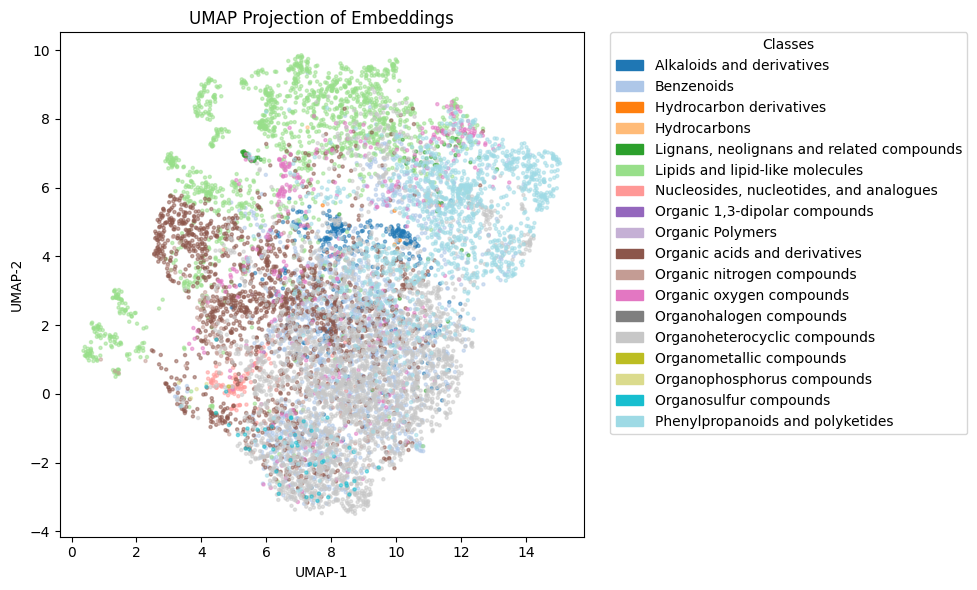

In [135]:
import umap
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np

embeddings = np.array(spectra_embeddings)
print(embeddings.shape)

# Run UMAP
reducer = umap.UMAP(n_neighbors=45, metric='cosine', min_dist=.5)
embeddings_2d = reducer.fit_transform(embeddings)

# Labels
labels = spectra_classes
unique_labels = np.unique(labels)
label_to_int = {label: i for i, label in enumerate(unique_labels)}
int_labels = np.array([label_to_int[l] for l in labels])

# Use a more diverse colormap
cmap = plt.cm.get_cmap("tab20", len(unique_labels))

# Scatter plot
plt.figure(figsize=(10, 6))
scatter = plt.scatter(
    embeddings_2d[:, 0],
    embeddings_2d[:, 1],
    c=int_labels,
    cmap=cmap,
    s=5,
    alpha=0.5
)

# Legend with matching colors
handles = [
    mpatches.Patch(color=cmap(label_to_int[lab]), label=lab)
    for lab in unique_labels
]

plt.legend(
    handles,
    unique_labels,
    title="Classes",
    bbox_to_anchor=(1.05, 1),
    loc="upper left",
    borderaxespad=0.
)

plt.title("UMAP Projection of Embeddings")
plt.xlabel("UMAP-1")
plt.ylabel("UMAP-2")
plt.tight_layout()
plt.show()


In [73]:
len(label_to_int)

16

In [75]:
len(unique_labels)

16